In [1]:
energy = 0.9
pressure= .004
radius = 12
energy = 0.9
lattice = "lattice.gsd"
random = "random.gsd"
logStableLiquid = "logStableLiquid"+"energy"+(str(energy).replace(".", ""))+".h5"
output = "random"+"energy"+(str(energy).replace(".", ""))+".gsd"
start_cavitation_gsd = "random"+"energy"+(str(energy).replace(".", ""))+"_cavitation.gsd"
cavity_h5 = "cavitation"+"r"+str(radius)+".h5"
cavity_done = "cavitation_done"+"r"+str(radius)+".gsd"

In [2]:
import itertools
import math
import gsd.hoomd
import hoomd
import numpy as np
import matplotlib.pyplot as plt
import fresnel
import scipy
import h5py
from scipy import ndimage
import time
import matplotlib
import importlib3
import os
# sbctc = importlib.import_module('thermocalcs',package='/home/tiarice/MDsims/sbcmd')
os.chdir('/home/tiarice/MDsims')
import sbcmd.thermocalcs as sbctc
import sbcmd.visualization as vis
import sbcmd.updated_surfacetension as surftens
os.chdir('/home/tiarice/MDsims/Sandboxes/Tia/md_simulation/Energy_09_Cavetation')

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
# This is not intended as a full tutorial on fresnel - see the
# fresnel user documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 192 / 255, 203 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L[0], L[1], L[2], 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L[0] * 2, L[1], L[2] * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L[2] * 1.4 + 1)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [4]:
def remove_particles_from_last_frame(input_gsd, output_gsd, r_cut):
    traj = gsd.hoomd.open(name=input_gsd, mode='r')
    snap = traj[-1]

    old_N = snap.particles.N
    pos = snap.particles.position
    dist = np.linalg.norm(pos, axis=1)
    keep_mask = dist > r_cut
    new_N = np.count_nonzero(keep_mask)

    snap.particles.N = new_N

    # loop through all particle attributes
    for attr in dir(snap.particles):
        if attr.startswith('_') or callable(getattr(snap.particles, attr)):
            continue

        value = getattr(snap.particles, attr)

        # only process NumPy arrays that match the original number of particles
        if isinstance(value, np.ndarray) and value.shape[0] == old_N:
            setattr(snap.particles, attr, value[keep_mask])

    # reassign tags to be contiguous and unique
    snap.particles.tag = np.arange(new_N, dtype=np.uint32)

    with gsd.hoomd.open(name=output_gsd, mode='w') as f_out:
        f_out.append(snap)


In [5]:
integrator = hoomd.md.Integrator(dt=1e-3) # was 1e-3 changed because higher temp means atoms have important interactions fast
cell = hoomd.md.nlist.Cell(buffer=0.2)
lj = hoomd.md.pair.LJ(nlist=cell) 
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 5.0
integrator.forces.append(lj)

In [6]:
# update r_cut
remove_particles_from_last_frame(output, start_cavitation_gsd, r_cut=12.0)


In [7]:
gpu = hoomd.device.GPU()
simulation = hoomd.Simulation(device=gpu, seed=1)
simulation.create_state_from_gsd(filename=start_cavitation_gsd)

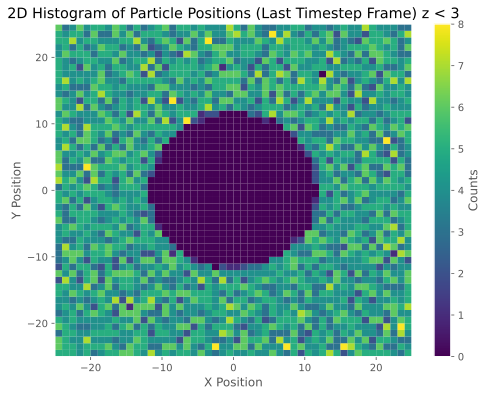

In [8]:
vis.colormap_histogram(start_cavitation_gsd)

In [9]:
#nvt --> nve
nve = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All())
integrator.methods.clear()  # Remove all existing methods
integrator.methods.append(nve)
simulation.operations.integrator = integrator

In [10]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
# thermodynamic_propertiesII = hoomd.md.compute.ThermodynamicQuantities(
#     filter=thisfilter)

In [11]:
simulation.operations.computes.append(thermodynamic_properties)
#simulation.operations.computes.append(thermodynamic_propertiesII)

In [12]:
simulation.always_compute_pressure = False
simulation.run(1)

In [13]:
# snapshot = simulation.state.get_snapshot()
# vis.plot_voxel_density_histogram(snapshot)

In [14]:
scale_factor = 5.5

In [15]:
initial_temperature = thermodynamic_properties.kinetic_temperature

In [16]:
#simulation.state.thermalize_particle_momenta(filter=thisfilter, kT=tempSpike) #change temp of filter particle 100, 14

In [17]:
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(thermodynamic_properties)
logger.add(simulation, quantities=['timestep', 'walltime'])

if os.path.exists(cavity_h5):
    os.remove(cavity_h5) # clear file if already created
    
hdf5_writer = hoomd.write.HDF5Log(trigger=hoomd.trigger.Periodic(10),
                                  filename=cavity_h5,
                                  mode='w',
                                  logger=logger)
simulation.operations.writers.append(hdf5_writer)

In [18]:
snapshots = []
snapshots.append(simulation.state.get_snapshot())

In [19]:
intervals = 5

In [20]:
for i in range(1, intervals + 1):
    simulation.run(100000/5)
    snapshots.append(simulation.state.get_snapshot())

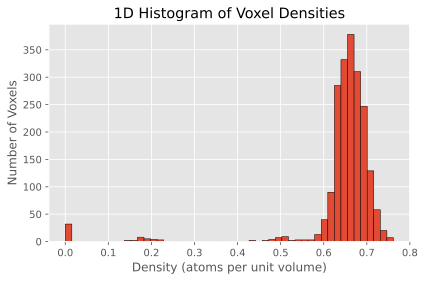

In [21]:
store=[]
store.append(vis.plot_voxel_density_histogram(snapshots[0]))

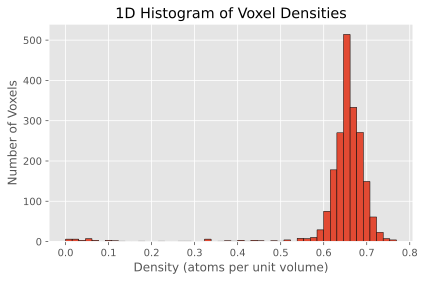

In [22]:
store.append(vis.plot_voxel_density_histogram(snapshots[1]))

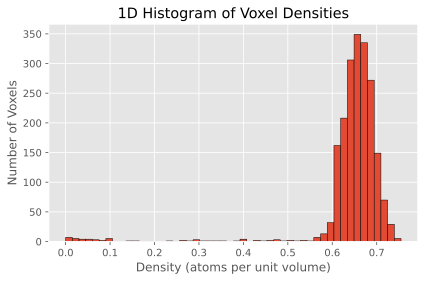

In [23]:
store.append(vis.plot_voxel_density_histogram(snapshots[2]))

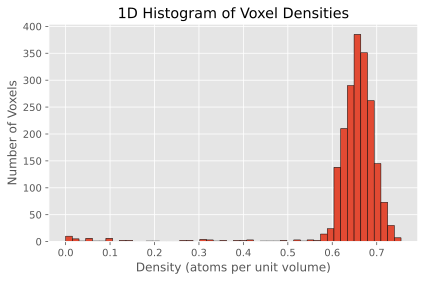

In [24]:
store.append(vis.plot_voxel_density_histogram(snapshots[3]))

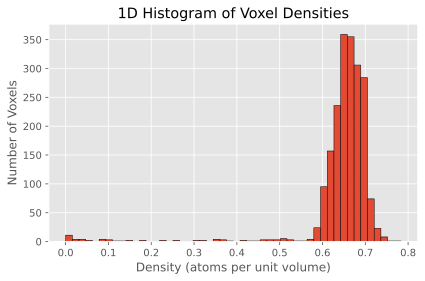

In [25]:
store.append(vis.plot_voxel_density_histogram(snapshots[4]))

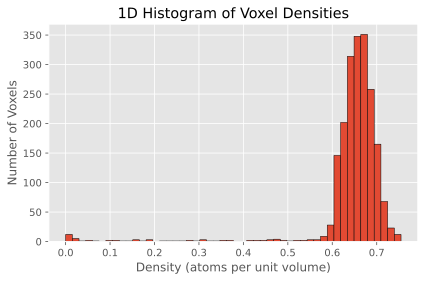

In [26]:
store.append(vis.plot_voxel_density_histogram(snapshots[5]))

In [27]:
percent_gas = []
for i in range(len(store)):
    percent_gas.append(store[i][0]/store[i][1])

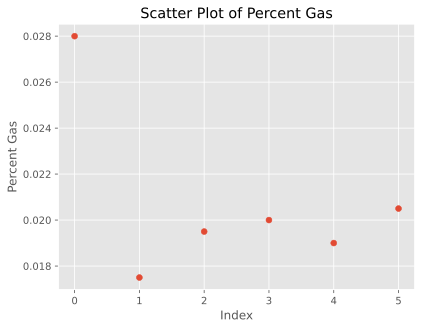

In [28]:
plt.scatter(range(len(percent_gas)), percent_gas)

# Labe
plt.xlabel('Index')
plt.ylabel('Percent Gas')
plt.title('Scatter Plot of Percent Gas')

plt.show()

In [29]:
# simulation.run(10000) # 10000

In [30]:
# snapshot = simulation.state.get_snapshot()
# vis.plot_voxel_density_histogram(snapshot)

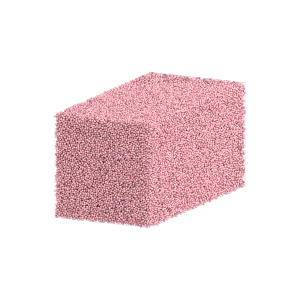

In [31]:
render(simulation.state.get_snapshot())

In [32]:
simulation.always_compute_pressure = True
simulation.run(1)
simulation.always_compute_pressure = False
thermodynamic_properties.pressure

-0.09519946159677987

In [33]:
# thermodynamic_propertiesII.pressure

In [34]:
# print("Filtered Particle Count:", thermodynamic_propertiesII.num_particles)

In [35]:
simulation.operations.writers.remove(hdf5_writer)
hdf5_file = h5py.File(name=cavity_h5, mode='r') # change name to normalized , case_one_spike etc.

In [36]:
#hdf5_file = h5py.File(name="heatSpike"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".h5", mode='r') # change name to normalized , case_one_spike etc.

In [37]:
#hdf5_file_spike = h5py.File(name='spike_case_four.h5', mode='r') # change name to normalized , case_one_spike etc.

In [38]:
def print_hdf5_structure(name, obj):
    print(name)

with h5py.File(cavity_h5, 'r') as hdf5_file_spike:
    hdf5_file.visititems(print_hdf5_structure)

hoomd-data
hoomd-data/Simulation
hoomd-data/Simulation/timestep
hoomd-data/Simulation/walltime
hoomd-data/md
hoomd-data/md/compute
hoomd-data/md/compute/ThermodynamicQuantities
hoomd-data/md/compute/ThermodynamicQuantities/degrees_of_freedom
hoomd-data/md/compute/ThermodynamicQuantities/kinetic_energy
hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature
hoomd-data/md/compute/ThermodynamicQuantities/num_particles
hoomd-data/md/compute/ThermodynamicQuantities/potential_energy
hoomd-data/md/compute/ThermodynamicQuantities/pressure
hoomd-data/md/compute/ThermodynamicQuantities/pressure_tensor
hoomd-data/md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom
hoomd-data/md/compute/ThermodynamicQuantities/rotational_kinetic_energy
hoomd-data/md/compute/ThermodynamicQuantities/translational_degrees_of_freedom
hoomd-data/md/compute/ThermodynamicQuantities/translational_kinetic_energy
hoomd-data/md/compute/ThermodynamicQuantities/volume


In [39]:
# # Accessing pressure data
# pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:])

# # Accessing pressure data for heated particles
# pressure_data_only_heated = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities_1/pressure'][:])

# # Accessing temperature data for heated particles
# temperature_data_only_heated = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities_1/kinetic_temperature'][:])


In [40]:
pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:])
temperature_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature'][:])

In [41]:
# pressure_data_only_heated = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities_1/pressure'][:])
# temperature_data_only_heated = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities_1/kinetic_energy'][:])

In [42]:
# current_temperature_spike = thermodynamic_propertiesII.kinetic_temperature
# print(current_temperature_spike)

In [43]:
# print("Temp Data:", temperature_data)

In [44]:
#pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:]) # pull data from log file

In [45]:
# current_pressure_spike = thermodynamic_propertiesII.pressure
# print(current_pressure_spike)

In [46]:
# print("Pressure Data:", pressure_data)

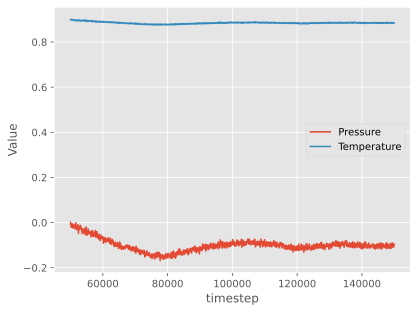

In [47]:
# pressure vs time
timesteps = np.float64(hdf5_file['hoomd-data/Simulation/timestep'][:])

plt.plot(timesteps, pressure_data, label='Pressure')
plt.plot(timesteps, temperature_data, label='Temperature')
plt.xlabel('timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

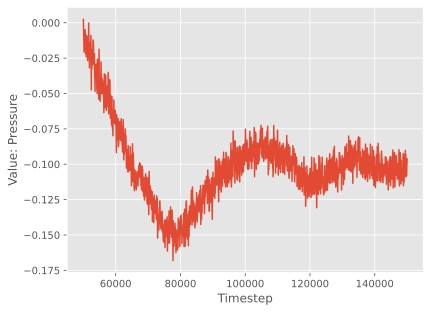

In [48]:
plt.plot(timesteps, pressure_data)
plt.xlabel('Timestep')
plt.ylabel('Value: Pressure')
plt.show()

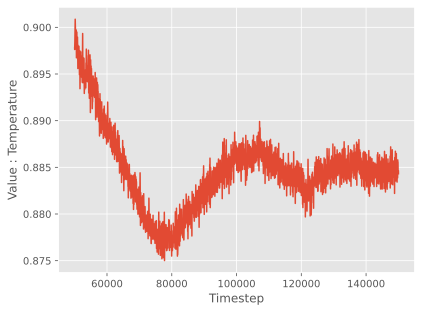

In [49]:
plt.plot(timesteps, temperature_data)
plt.xlabel('Timestep')
plt.ylabel('Value : Temperature')
plt.show()

In [50]:
if os.path.exists(cavity_done):
    os.remove(cavity_done) # clear file if already created
hoomd.write.GSD.write(state=simulation.state, filename=cavity_done)

In [51]:
# # gsd_filename = "cavitation_done"+"r"+str(radius)+".gsd"
# # vis.colormap_histogram(gsd_filename, in_bins=50, z=3, x1_name="X Position", x2_name="Y Position")
# vis.colormap_histogram_velocity("cavitation_done"+"r"+str(radius)+".gsd")

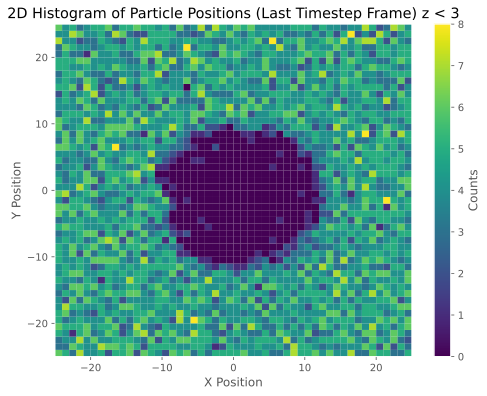

In [52]:
vis.colormap_histogram(cavity_done)

In [53]:
thermodynamic_properties.kinetic_temperature

0.8840855783656897

In [54]:
thermodynamic_properties.kinetic_energy

238391.4659923623